In [1]:
import itertools

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support

In [2]:
# Fix random seed 
np.random.seed(13)

# Function Definitions 

In [3]:
metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_score']

def compute_scores(y_true, y_pred): 
    d = {}
    
    for metric in metrics: 
        if metric == 'accuracy': 
            d[metric] = accuracy_score(y_true, y_pred)
        elif metric == 'balanced_accuracy': 
            d[metric] = balanced_accuracy_score(y_true, y_pred)
        elif metric == 'precision': 
            d[metric] = precision_score(y_true, y_pred)
        elif metric == 'recall': 
            d[metric] = recall_score(y_true, y_pred)
        elif metric == 'f1_score': 
            d[metric] = f1_score(y_true, y_pred)
        else: 
            raise ValueError('You provided a non-supported evaluation metric.')
            
    return d

In [200]:
def binary_classification(features, labels, disorders, estimator, param_grid, scale_features, scenario, verbose=True):
    
    # Initialize results 
    results = {}
    predictions = {}

    for disorder in disorders: 
        if disorder == 'No Diagnosis Given': 
            continue

        if scenario == 'Disorder vs No Diagnosis':
            # Preserve subjects that belong to either class
            mask = (labels[disorder] == 1) | (labels['No Diagnosis Given'] == 1)
            
            X = features[mask.values].values
            Y = labels[mask.values]
            
        elif scenario == 'Disorder vs Rest':
            # Preserve all subjects
            X = features.values
            Y = labels
        else: 
            raise ValueError('Incorrect scenario value!')

        # Binary labels for current disorder 
        y_true = Y[disorder].values.astype(int)

        skf = StratifiedKFold(n_splits=5, shuffle=True)

        # Initialize
        y_pred = np.empty(len(y_true))

        for train_index, test_index in skf.split(X, y_true):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_true[train_index], y_true[test_index]

            # Pre-processing 
            if scale_features:
                scaler = StandardScaler()
                Z_train = scaler.fit_transform(X_train)
            else:
                Z_train = X_train

            N = len(y_train)
            N_0 = np.sum(y_train == 0)
            N_1 = np.sum(y_train == 1)
            
            param_grid['class_weight'] = [{0: N/N_0, 1: (N_0/N_1)*N/N_1}]
            
            # Hyper-parameter tuning 
            _classifier = estimator

            search = GridSearchCV(
                        estimator=_classifier,
                        param_grid=param_grid,
                        scoring='f1',
                        n_jobs=-1,
                        iid=False,
                        cv=StratifiedKFold(n_splits=5))

            search.fit(Z_train, y_train)

            best_params = search.best_params_

            # Train on the "best" configuration 
            classifier = estimator
            classifier.set_params(**best_params)
            classifier.fit(Z_train, y_train)

            # Testing 
            if scale_features: 
                Z_test = scaler.transform(X_test)
            else: 
                Z_test = X_test 
                
            y_pred[test_index] = classifier.predict(Z_test)

        # Results 
        results[disorder] = compute_scores(y_true, y_pred)
        predictions[disorder] = y_pred

        if verbose: 
            print('================================= {0} ================================='.format(disorder))

            print('accuracy {:.3f} balanced_accuracy {:.3f} precision {:.3f} recall {:.3f} f1_score {:.3f}' \
                      .format(results[disorder]['accuracy'], results[disorder]['balanced_accuracy'], 
                              results[disorder]['precision'], results[disorder]['recall'], results[disorder]['f1_score']))
            
    return results, predictions

# Behavioural Data 

In [5]:
behaviour_data = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

# Drop patients with incomplete diagnosis
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'No Diagnosis Given', 'Communication Disorder',
                         'Depressive Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

behaviour_data

Removing 282 patients as their evaluation was incomplete.
Removing 73 patients as their diagnoses were very uncommon.


,Anonymized.ID,EID,Sex,Age,Study.Site,NoDX,DX_01_Cat,DX_01_Sub,DX_01,DX_01_Spec,...,WISC_PSI,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total
0,A00078864,NDARYM832PX3,1,7.048254,1,Yes,Anxiety Disorders,NaN,Generalized Anxiety Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A00078865,NDARNJ687DMC,1,6.348163,1,Yes,Depressive Disorders,NaN,Disruptive Mood Dysregulation Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A00078866,NDARRM363BXZ,0,10.052589,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A00078867,NDARUW586LLL,1,12.319415,1,Yes,Depressive Disorders,NaN,Major Depressive Disorder,Single episode,...,NaN,NaN,9.0,12.0,8.0,7.0,9.0,16.0,29.0,85.0
4,A00078868,NDARDC298NW4,0,13.901437,1,Yes,Neurodevelopmental Disorders,Intellectual Disability,Intellectual Disability-Mild,NaN,...,NaN,NaN,8.0,10.0,5.0,2.0,11.0,10.0,26.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,A00093552,NDARJX939UCQ,1,10.203057,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,103.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1737,A00093553,NDARJJ817UP1,0,9.126397,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,NaN,...,100.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1738,A00093557,NDARYZ986HEW,1,7.563084,3,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,116.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1739,A00093558,NDARPM572ZZV,0,9.832762,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,rule out,...,98.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# no_diagnosis_given = 'No Diagnosis Given'

# if no_diagnosis_given in most_common_disorders:
#     no_diag_index = most_common_disorders.index(no_diagnosis_given)
#     most_common_disorders = most_common_disorders[:no_diag_index] + \
#         most_common_disorders[no_diag_index + 1:]
    
# print('Most common disorders: ', most_common_disorders)

In [7]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

classes = np.transpose(classes)
classes = np.column_stack((behaviour_data['EID'], classes))

labels = pd.DataFrame(data=classes, columns=['ID'] + most_common_disorders)
labels

,ID,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,No Diagnosis Given,Communication Disorder,Depressive Disorders
0,NDARYM832PX3,0,1,1,0,0,0,0,0
1,NDARNJ687DMC,0,0,0,0,0,0,0,1
2,NDARRM363BXZ,1,0,0,0,0,0,0,0
3,NDARUW586LLL,0,0,0,0,0,0,0,1
4,NDARDC298NW4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1736,NDARJX939UCQ,1,0,0,0,1,0,1,0
1737,NDARJJ817UP1,0,0,1,0,0,0,0,0
1738,NDARYZ986HEW,1,1,0,0,1,0,0,0
1739,NDARPM572ZZV,0,0,1,0,0,0,0,0


# Disorder vs No Diagnosis Given

## FA Per Tract

In [8]:
fa_per_tract = pd.read_csv('data/MRI/MRI/DTI/FAPerTract.csv', low_memory=False)

# Remove "/" from the end some IDs 
fa_per_tract['ID'] = fa_per_tract['ID'].apply(lambda x: x[:-1] if "/" in x else x)

# Keep patients who have both behavioural records and MRI
fa_patient_IDs = np.array(list(set(behaviour_data['EID'].values) & set(fa_per_tract['ID'].values)))
fa_per_tract = fa_per_tract[fa_per_tract['ID'].isin(fa_patient_IDs)].sort_values(by='ID')
labels_fa_tr = labels[labels['ID'].isin(fa_patient_IDs)].sort_values(by='ID')

print('Number of patients: ', len(fa_patient_IDs))

Number of patients:  801


In [9]:
fa_per_tract

,LeftThalamicRadiation,RightThalamicRadiation,LeftCorticospinal,RightCorticospinal,LeftCingulumCingulate,RightCingulumCingulate,LeftCingulumHippocampus,RightCingulumHippocampus,CallosumForcepsMajor,CallosumForcepsMinor,...,RightILF,LeftSLF,RightSLF,LeftUncinate,RightUncinate,LeftArcuate,RightArcuate,GlobalFA,ID,ScanSite
0,0.455656,0.453115,0.620558,0.618361,0.517805,0.444551,NaN,0.297005,NaN,0.574576,...,0.420072,0.502264,0.518771,0.368745,0.423124,0.561095,0.470981,0.454698,NDARAA536PTU,SI
290,0.440407,0.420813,0.553176,0.566157,0.442870,0.462149,NaN,NaN,0.534137,0.512610,...,0.424499,0.457156,0.436721,0.394274,0.419798,0.491984,0.424049,0.439574,NDARAA948VFH,RU
774,0.360179,0.400220,0.480111,0.499736,0.408975,0.406019,0.352879,0.291959,0.503494,0.524352,...,0.406348,0.430824,0.481923,0.367575,0.405958,0.484720,0.485776,0.404561,NDARAC349YUC,CBIC
291,0.412105,0.428844,0.578922,0.594946,NaN,NaN,NaN,NaN,NaN,0.489935,...,0.433091,0.352073,0.380953,0.387661,0.449428,0.376423,0.435387,0.406589,NDARAC853DTE,RU
776,0.287333,NaN,0.367654,0.330376,NaN,NaN,NaN,NaN,NaN,0.432363,...,0.321627,0.421391,0.344268,0.368084,0.514472,0.421558,NaN,0.356337,NDARAC857HDB,CBIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0.445741,0.496935,0.520404,0.497049,NaN,NaN,NaN,NaN,0.606643,0.566425,...,0.374876,0.349277,0.411196,0.400458,0.405271,0.452404,0.447451,0.428610,NDARZW472CCF,RU
975,NaN,NaN,NaN,NaN,0.319956,NaN,NaN,NaN,NaN,NaN,...,0.428308,0.413686,0.438971,NaN,0.325042,0.479818,0.426632,0.365432,NDARZW873DN3,CBIC
772,0.399457,0.383633,0.526873,0.498594,0.340887,NaN,NaN,0.409829,0.570211,0.548486,...,0.330544,0.398634,0.422165,0.397124,0.444051,0.501421,0.461800,0.417440,NDARZW930MF2,RU
976,NaN,NaN,NaN,NaN,0.344458,NaN,NaN,NaN,NaN,NaN,...,0.344348,0.298890,0.347665,NaN,NaN,NaN,0.363475,0.299453,NDARZY101JNB,CBIC


In [10]:
labels_fa_tr

,ID,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,No Diagnosis Given,Communication Disorder,Depressive Disorders
278,NDARAA536PTU,1,0,0,0,0,0,0,0
1004,NDARAA948VFH,1,0,0,0,0,0,0,0
1265,NDARAC349YUC,1,0,0,0,0,0,0,0
928,NDARAC853DTE,1,1,0,0,0,0,0,0
1616,NDARAC857HDB,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1412,NDARZW472CCF,1,0,0,0,0,0,0,0
1392,NDARZW873DN3,0,1,0,0,0,0,1,0
980,NDARZW930MF2,0,1,0,0,0,0,0,0
1425,NDARZY101JNB,0,0,0,1,0,0,0,0


In [11]:
# Fill in missing values in MRI data
median_mri = fa_per_tract.median(axis=0, skipna=True)

fa_per_tract = fa_per_tract.fillna(value=median_mri, axis=0)

# Drop ID column
fa_per_tract = fa_per_tract.drop(columns=['ID'])

# Convert site to integer ID
scan_sites = fa_per_tract['ScanSite'].unique()
map_site_to_ID = {site: i for i, site in enumerate(scan_sites)}
fa_per_tract['ScanSite'] = fa_per_tract['ScanSite'].apply(lambda x: map_site_to_ID[x])

### Random Forest 

In [12]:
rf_param_grid = {'n_estimators': [100], 
                 'max_depth': np.linspace(start=4,stop=20,num=5),
                 'max_features': np.linspace(start=0.2,stop=1,num=5),
                 'n_jobs': [-1], 
                 'class_weight': ['balanced']}

rf_res_vs_no_diag, rf_y_pred_vs_no_diag = binary_classification(fa_per_tract, 
                                                                labels_fa_tr, 
                                                                most_common_disorders, 
                                                                RandomForestClassifier(), 
                                                                rf_param_grid,
                                                                scale_features=True,
                                                                scenario='Disorder vs No Diagnosis')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.798 balanced_accuracy 0.505 precision 0.808 recall 0.983 f1_score 0.887
================================= Anxiety Disorders =================================
accuracy 0.649 balanced_accuracy 0.545 precision 0.683 recall 0.873 f1_score 0.766
================================= Specific Learning Disorder =================================
accuracy 0.550 balanced_accuracy 0.549 precision 0.584 recall 0.570 f1_score 0.577
================================= Autism Spectrum Disorder =================================
accuracy 0.623 balanced_accuracy 0.624 precision 0.652 recall 0.603 f1_score 0.627
================================= Disruptive =================================
accuracy 0.526 balanced_accuracy 0.525 precision 0.545 recall 0.550 f1_score 0.548
================================= Communication Disorder =================================
accuracy 0.603 balanced_accuracy

### SVM

In [15]:
svm_param_grid = {'C': np.logspace(-10, 10, 5), 
                  'kernel': ['rbf'],
                  'gamma': ['scale', 'auto'] + np.logspace(-2, 0, 5).tolist(),
                  'class_weight': ['balanced']}

svm_res_vs_no_diag, svm_y_pred_vs_no_diag = binary_classification(fa_per_tract, 
                                                                  labels_fa_tr, 
                                                                  most_common_disorders, 
                                                                  SVC(), 
                                                                  svm_param_grid,
                                                                  scale_features=False,
                                                                  scenario='Disorder vs No Diagnosis')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.682 balanced_accuracy 0.547 precision 0.826 recall 0.767 f1_score 0.795
================================= Anxiety Disorders =================================
accuracy 0.643 balanced_accuracy 0.606 precision 0.732 recall 0.722 f1_score 0.727
================================= Specific Learning Disorder =================================
accuracy 0.546 balanced_accuracy 0.520 precision 0.550 recall 0.867 f1_score 0.673
================================= Autism Spectrum Disorder =================================
accuracy 0.563 balanced_accuracy 0.559 precision 0.575 recall 0.636 f1_score 0.604
================================= Disruptive =================================
accuracy 0.591 balanced_accuracy 0.588 precision 0.597 recall 0.667 f1_score 0.630
================================= Communication Disorder =================================
accuracy 0.558 balanced_accuracy


### Results

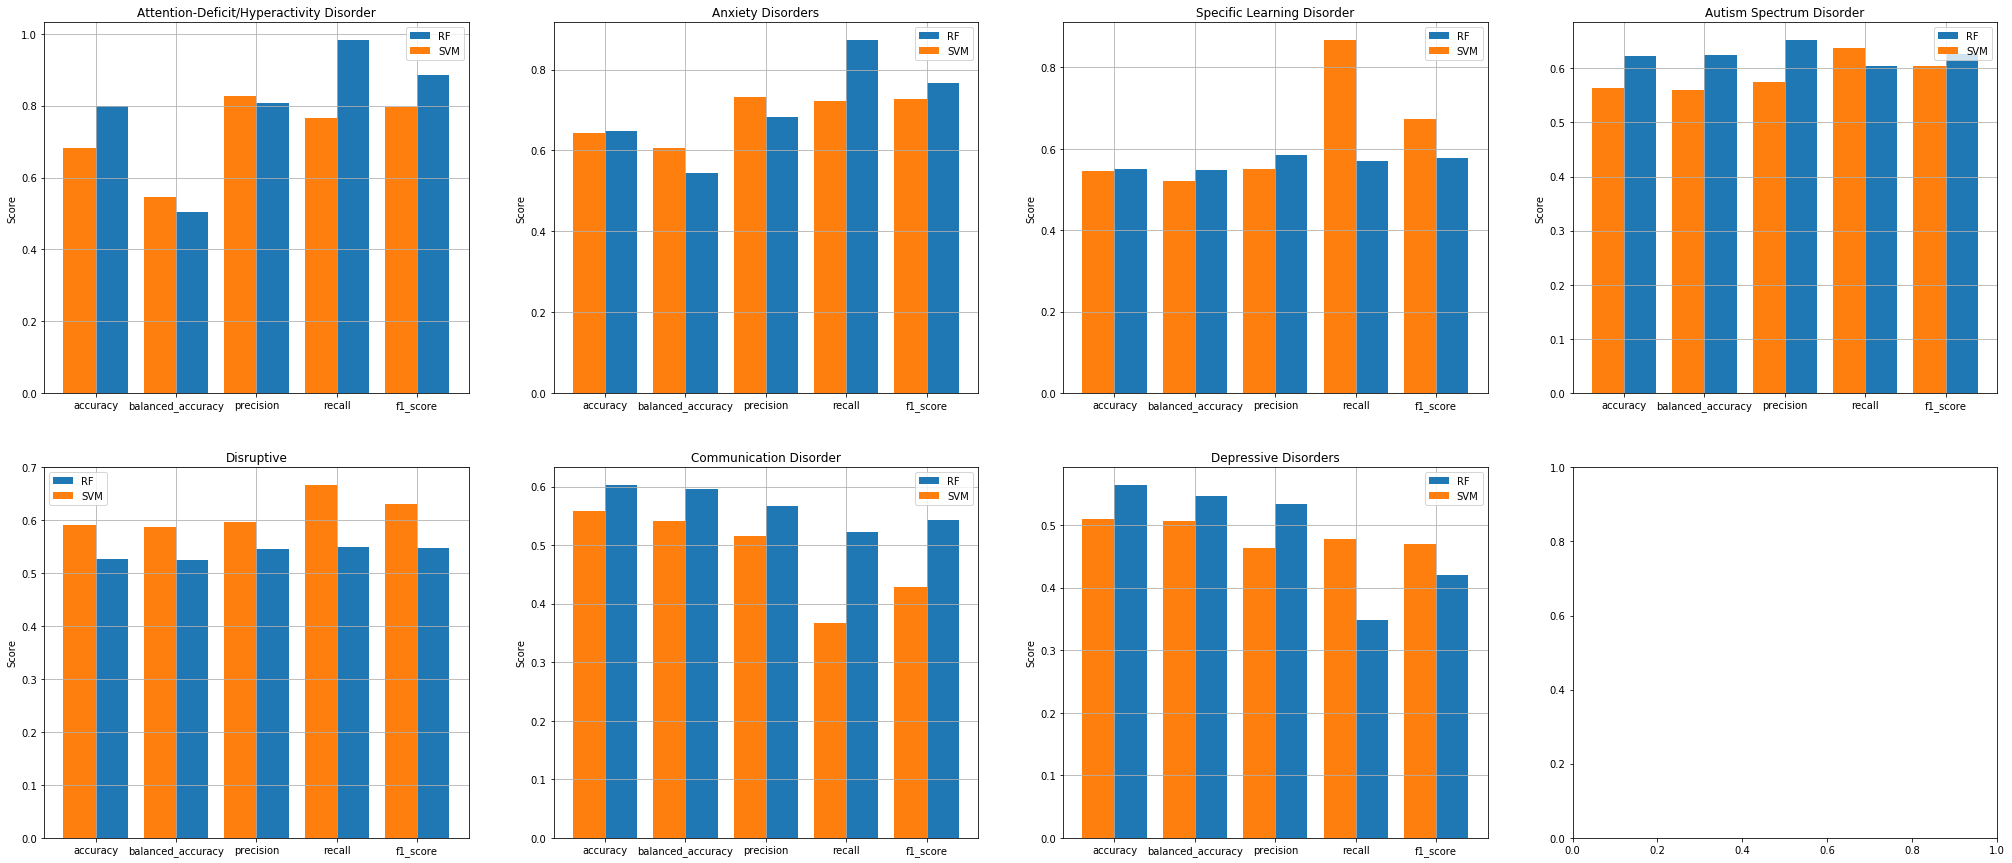

In [55]:
fig, axs = plt.subplots(nrows= 2, ncols=4, figsize=(35,15))

for ax, disorder in zip(axs.flat, rf_res_vs_no_diag.keys()):
    metrics = [m for m in rf_res_vs_no_diag[disorder].keys()]
    rf_scores = [v for v in rf_res_vs_no_diag[disorder].values()]
    svm_scores = [v for v in svm_res_vs_no_diag[disorder].values()]
    
    x = np.arange(len(metrics)) # label locations 
    width = 0.4 # the width of the bars
    
    rects_rf = ax.bar(x + width/2, rf_scores, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_scores, width, label='SVM')
                             
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()
                             
plt.show()

## Structural MRI

We will consider merging all tables together into a single table (features). For that we will keep only one column descriping the scan site and eTIV (common to all tables). 

In [56]:
cort_thick_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessLHROI.csv', low_memory=False)

cort_thick_l.head()

,ID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,lh_S_precentral.sup.part_thickness,lh_S_suborbital_thickness,lh_S_subparietal_thickness,lh_S_temporal_inf_thickness,lh_S_temporal_sup_thickness,lh_S_temporal_transverse_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV,ScanSite
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,2.615,2.777,2.596,2.694,2.693,2.621,2.78542,1163044,1.430219e+06,SI
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,2.562,2.623,2.339,2.732,2.758,2.321,2.72152,1203675,1.565744e+06,SI
2,NDARAD481FXF,2.544,2.585,2.410,2.837,2.990,2.857,2.674,2.786,2.991,...,2.566,2.735,2.416,2.475,2.599,2.275,2.64461,1238668,1.722067e+06,SI
3,NDARAE199TDD,2.378,2.456,2.531,2.811,2.754,2.948,2.910,2.744,3.103,...,2.577,3.035,2.518,2.668,2.701,2.655,2.60595,1179246,1.491174e+06,SI
4,NDARAJ366ZFA,2.789,2.436,2.281,2.598,2.905,3.078,2.697,2.655,3.034,...,2.449,2.922,2.434,2.625,2.622,2.258,2.59074,1007569,1.331829e+06,SI


In [57]:
cort_thick_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessRHROI.csv', low_memory=False)

cort_thick_r = cort_thick_r.drop(columns=['eTIV', 'ScanSite'])
cort_thick_r.head()

,ID,rh_G.S_frontomargin_thickness,rh_G.S_occipital_inf_thickness,rh_G.S_paracentral_thickness,rh_G.S_subcentral_thickness,rh_G.S_transv_frontopol_thickness,rh_G.S_cingul.Ant_thickness,rh_G.S_cingul.Mid.Ant_thickness,rh_G.S_cingul.Mid.Post_thickness,rh_G_cingul.Post.dorsal_thickness,...,rh_S_postcentral_thickness,rh_S_precentral.inf.part_thickness,rh_S_precentral.sup.part_thickness,rh_S_suborbital_thickness,rh_S_subparietal_thickness,rh_S_temporal_inf_thickness,rh_S_temporal_sup_thickness,rh_S_temporal_transverse_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent
0,NDARAA075AMK,2.784,2.962,2.348,2.972,3.008,2.969,2.917,2.731,3.161,...,2.586,2.645,2.640,3.333,2.562,2.786,2.837,3.089,2.82064,1163044
1,NDARAA536PTU,2.483,2.882,2.505,2.902,2.827,2.853,2.915,2.822,3.182,...,2.328,2.521,2.460,2.617,2.495,2.660,2.683,2.383,2.70309,1203675
2,NDARAD481FXF,2.384,2.547,2.421,2.821,3.104,2.712,2.777,2.677,2.818,...,2.294,2.600,2.446,2.453,2.440,2.472,2.701,2.723,2.64806,1238668
3,NDARAE199TDD,2.460,2.442,2.333,2.674,2.661,2.883,2.811,2.908,3.103,...,2.462,2.648,2.603,2.906,2.546,2.746,2.684,2.941,2.60237,1179246
4,NDARAJ366ZFA,2.727,2.702,2.277,2.690,2.724,2.867,2.709,2.700,3.151,...,2.294,2.469,2.654,2.523,2.541,2.631,2.772,3.160,2.66911,1007569


In [58]:
cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeLHROI.csv', low_memory=False)

cort_vol_l = cort_vol_l.drop(columns=['eTIV', 'ScanSite'])
cort_vol_l.head()

,ID,lh_G.S_frontomargin_volume,lh_G.S_occipital_inf_volume,lh_G.S_paracentral_volume,lh_G.S_subcentral_volume,lh_G.S_transv_frontopol_volume,lh_G.S_cingul.Ant_volume,lh_G.S_cingul.Mid.Ant_volume,lh_G.S_cingul.Mid.Post_volume,lh_G_cingul.Post.dorsal_volume,...,lh_S_pericallosal_volume,lh_S_postcentral_volume,lh_S_precentral.inf.part_volume,lh_S_precentral.sup.part_volume,lh_S_suborbital_volume,lh_S_subparietal_volume,lh_S_temporal_inf_volume,lh_S_temporal_sup_volume,lh_S_temporal_transverse_volume,BrainSegVolNotVent
0,NDARAA075AMK,2537,3984,3734,3921,2530,5344,2675,2654,2086,...,1395,4230,2522,2664,1252,2271,3647,11423,662,1163044
1,NDARAA536PTU,3007,3783,3014,4842,2272,5052,3166,2798,2379,...,1762,4860,4166,2116,1554,1286,3241,13213,834,1203675
2,NDARAD481FXF,2929,4492,2965,4222,2496,4802,2154,3050,1797,...,1280,4769,2653,3063,1572,1788,1979,11081,911,1238668
3,NDARAE199TDD,2818,3402,4553,4934,2103,4778,2674,3501,1926,...,1310,5216,3641,2077,2028,1808,3516,9591,605,1179246
4,NDARAJ366ZFA,2949,3392,2576,3657,2351,4187,2136,2404,1754,...,1286,4041,2797,1981,1140,1354,2040,10467,691,1007569


In [59]:
cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeRHROI.csv', low_memory=False)

cort_vol_r = cort_vol_r.drop(columns=['eTIV', 'ScanSite'])
cort_vol_r.head()

,ID,rh_G.S_frontomargin_volume,rh_G.S_occipital_inf_volume,rh_G.S_paracentral_volume,rh_G.S_subcentral_volume,rh_G.S_transv_frontopol_volume,rh_G.S_cingul.Ant_volume,rh_G.S_cingul.Mid.Ant_volume,rh_G.S_cingul.Mid.Post_volume,rh_G_cingul.Post.dorsal_volume,...,rh_S_pericallosal_volume,rh_S_postcentral_volume,rh_S_precentral.inf.part_volume,rh_S_precentral.sup.part_volume,rh_S_suborbital_volume,rh_S_subparietal_volume,rh_S_temporal_inf_volume,rh_S_temporal_sup_volume,rh_S_temporal_transverse_volume,BrainSegVolNotVent
0,NDARAA075AMK,2239,2847,2950,4097,4045,6140,2787,3205,2078,...,1193,4084,2969,2166,819,2253,2016,13378,433,1163044
1,NDARAA536PTU,2276,3937,2557,3738,3342,7035,3697,3464,2157,...,1794,3949,2287,3111,705,1881,2542,12503,681,1203675
2,NDARAD481FXF,2182,2864,2828,3767,3495,6432,3234,3304,1660,...,1827,3029,3231,3061,532,2114,2375,11006,525,1238668
3,NDARAE199TDD,2212,2661,2805,3744,3360,6394,3220,3077,1695,...,1183,4976,2390,2606,540,2519,1775,10427,474,1179246
4,NDARAJ366ZFA,2121,2813,2876,2637,2983,5158,2136,2626,1644,...,1221,3085,1393,1910,404,1459,2114,10696,396,1007569


In [60]:
sub_cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeLHROI.csv', low_memory=False)

sub_cort_vol_l = sub_cort_vol_l.drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_l.head()

,ID,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,...,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,BrainSegVolNotVent
0,NDARAA075AMK,2620,1557,7569,3394,1777,11615,17965,14871,3397,...,22054,28647,14504,14631,11260,1279,2065,1198,8120,1163044
1,NDARAA536PTU,3997,2064,8685,3968,1827,10736,13907,15831,3201,...,22393,29687,14302,17490,16639,1033,2728,1575,8855,1203675
2,NDARAD481FXF,2448,1572,6925,3857,2249,11908,15787,13426,2878,...,19555,28820,15161,14622,13690,1605,2549,1418,8016,1238668
3,NDARAE199TDD,2749,2118,7176,4073,1440,10891,15611,10556,2936,...,21036,24353,17669,12520,15564,1242,2035,1292,7116,1179246
4,NDARAJ366ZFA,3266,1659,5506,3003,1606,8672,13777,11025,3194,...,15484,21556,14132,14035,12019,1258,2825,1175,6893,1007569


In [61]:
sub_cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeRHROI.csv', low_memory=False)

sub_cort_vol_r = sub_cort_vol_r.drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_r.head()

,ID,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,...,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent
0,NDARAA075AMK,2644,1878,7640,3385,1550,12074,21654,11967,3028,...,23310,28109,15406,14267,12552,1788,2667,1038,6893,1163044
1,NDARAA536PTU,2411,2744,7146,4073,2002,12453,19378,14207,3144,...,20887,28753,13475,16053,11576,1465,3062,1406,9631,1203675
2,NDARAD481FXF,2545,2370,8183,3910,1994,10557,18780,12283,2705,...,18474,27400,15945,14899,12247,1548,2587,1122,7734,1238668
3,NDARAE199TDD,2162,1378,5722,4855,1510,11434,16093,11760,2812,...,21894,26249,20132,12680,12751,1246,2469,1063,7032,1179246
4,NDARAJ366ZFA,2463,1528,4250,3348,1882,10093,16268,11554,2159,...,16755,20850,12257,13107,9861,1689,2280,918,6808,1007569


In [62]:
glob_thick = pd.read_csv('data/MRI/MRI/structuralMRI/GlobalCorticalThickness.csv', low_memory=False)

glob_thick = glob_thick.drop(columns=['ScanSite'])
glob_thick.head()

,ID,GlobalCorticalThickness
0,NDARAA075AMK,2.803030
1,NDARAA536PTU,2.712315
2,NDARAD481FXF,2.646340
3,NDARAE199TDD,2.604245
4,NDARAJ366ZFA,2.630035


In [184]:
# Join tables 
struct_mri = pd.merge(cort_thick_l, cort_thick_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, glob_thick, on='ID', how='inner')

struct_mri.head()

,ID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,28109,15406,14267,12552,1788,2667,1038,6893,1163044,2.803030
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,28753,13475,16053,11576,1465,3062,1406,9631,1203675,2.712315
2,NDARAD481FXF,2.544,2.585,2.410,2.837,2.990,2.857,2.674,2.786,2.991,...,27400,15945,14899,12247,1548,2587,1122,7734,1238668,2.646340
3,NDARAE199TDD,2.378,2.456,2.531,2.811,2.754,2.948,2.910,2.744,3.103,...,26249,20132,12680,12751,1246,2469,1063,7032,1179246,2.604245
4,NDARAJ366ZFA,2.789,2.436,2.281,2.598,2.905,3.078,2.697,2.655,3.034,...,20850,12257,13107,9861,1689,2280,918,6808,1007569,2.630035


In [185]:
# Remove "/" from the end some IDs 
struct_mri['ID'] = struct_mri['ID'].apply(lambda x: x[:-1] if "/" in x else x)

# Keep patients who have both behavioural records and MRI
struct_patient_IDs = np.array(list(set(behaviour_data['EID'].values) & set(struct_mri['ID'].values)))
struct_mri = struct_mri[struct_mri['ID'].isin(struct_patient_IDs)].sort_values(by='ID')
labels_str = labels[labels['ID'].isin(struct_patient_IDs)].sort_values(by='ID')

print('Number of patients: ', len(struct_patient_IDs))

## Add Sex and Age to features 
struct_mri.rename(columns={'ID': 'EID'}, inplace=True) 
struct_mri = pd.merge(
                struct_mri, 
                behaviour_data[behaviour_data['EID'].isin(struct_patient_IDs)].sort_values(by='EID')[['EID','Sex', 'Age']],
                on='EID',
                how='inner')

Number of patients:  1027


In [186]:
struct_mri

,EID,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness,Sex,Age
0,NDARAA075AMK,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,...,14267,12552,1788,2667,1038,6893,1163044,2.803030,1,6.728040
1,NDARAA536PTU,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,...,16053,11576,1465,3062,1406,9631,1203675,2.712315,0,11.998402
2,NDARAA948VFH,2.750,2.679,2.703,3.432,3.246,3.391,3.161,3.089,3.480,...,13756,11335,1461,2682,1095,6799,1107657,2.928645,1,7.982660
3,NDARAC349YUC,2.392,2.941,2.570,2.612,2.556,3.279,3.056,3.232,3.388,...,12823,12948,945,2630,1126,8154,1154134,2.745770,1,10.051791
4,NDARAC350XUM,2.724,2.256,2.385,2.450,3.108,2.956,3.109,2.789,2.832,...,12067,12013,1891,2202,953,8739,1275317,2.498120,0,8.211955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,NDARZW873DN3,2.710,2.551,3.130,3.149,2.836,3.188,3.201,3.137,3.276,...,13675,11022,1386,2710,965,8743,1276325,2.820720,1,13.436344
1023,NDARZW930MF2,2.632,2.500,2.210,2.810,2.603,3.109,3.043,2.965,3.284,...,12707,10961,1323,3052,1216,7754,1164539,2.706000,0,10.156399
1024,NDARZY101JNB,2.864,2.867,2.924,3.173,3.009,3.208,3.229,2.997,3.521,...,15479,15710,1405,2802,1217,8770,1289003,2.996145,0,7.517111
1025,NDARZY668NMV,2.849,2.659,2.638,2.952,3.304,3.135,3.225,2.897,3.032,...,11910,12836,1430,2626,934,6611,1008736,2.717490,1,11.623431


In [187]:
labels_str

,ID,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,No Diagnosis Given,Communication Disorder,Depressive Disorders
302,NDARAA075AMK,0,0,0,0,0,1,0,0
278,NDARAA536PTU,1,0,0,0,0,0,0,0
1004,NDARAA948VFH,1,0,0,0,0,0,0,0
1265,NDARAC349YUC,1,0,0,0,0,0,0,0
1559,NDARAC350XUM,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1392,NDARZW873DN3,0,1,0,0,0,0,1,0
980,NDARZW930MF2,0,1,0,0,0,0,0,0
1425,NDARZY101JNB,0,0,0,1,0,0,0,0
712,NDARZY668NMV,1,0,0,0,1,0,0,0


In [188]:
# Check that IDs from the features and labels tables match
if any(struct_mri['EID'].values != labels_str['ID'].values):
    raise ValueError('There is a mismatch in IDs!')

In [189]:
# Drop ID column
struct_mri = struct_mri.drop(columns=['EID'])

# Convert site to integer ID
scan_sites = struct_mri['ScanSite'].unique()
map_site_to_ID = {site: i for i, site in enumerate(scan_sites)}
struct_mri['ScanSite'] = struct_mri['ScanSite'].apply(lambda x: map_site_to_ID[x])

struct_mri

/Users/adamossolomou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,lh_G.S_frontomargin_thickness,lh_G.S_occipital_inf_thickness,lh_G.S_paracentral_thickness,lh_G.S_subcentral_thickness,lh_G.S_transv_frontopol_thickness,lh_G.S_cingul.Ant_thickness,lh_G.S_cingul.Mid.Ant_thickness,lh_G.S_cingul.Mid.Post_thickness,lh_G_cingul.Post.dorsal_thickness,lh_G_cingul.Post.ventral_thickness,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,BrainSegVolNotVent_y,GlobalCorticalThickness,Sex,Age
0,2.683,2.715,2.422,2.856,3.240,2.978,2.887,2.779,3.188,2.774,...,14267,12552,1788,2667,1038,6893,1163044,2.803030,1,6.728040
1,2.432,2.871,2.536,2.790,2.782,2.971,2.832,2.994,2.932,2.729,...,16053,11576,1465,3062,1406,9631,1203675,2.712315,0,11.998402
2,2.750,2.679,2.703,3.432,3.246,3.391,3.161,3.089,3.480,3.149,...,13756,11335,1461,2682,1095,6799,1107657,2.928645,1,7.982660
3,2.392,2.941,2.570,2.612,2.556,3.279,3.056,3.232,3.388,3.365,...,12823,12948,945,2630,1126,8154,1154134,2.745770,1,10.051791
4,2.724,2.256,2.385,2.450,3.108,2.956,3.109,2.789,2.832,3.067,...,12067,12013,1891,2202,953,8739,1275317,2.498120,0,8.211955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,2.710,2.551,3.130,3.149,2.836,3.188,3.201,3.137,3.276,3.069,...,13675,11022,1386,2710,965,8743,1276325,2.820720,1,13.436344
1023,2.632,2.500,2.210,2.810,2.603,3.109,3.043,2.965,3.284,3.073,...,12707,10961,1323,3052,1216,7754,1164539,2.706000,0,10.156399
1024,2.864,2.867,2.924,3.173,3.009,3.208,3.229,2.997,3.521,3.252,...,15479,15710,1405,2802,1217,8770,1289003,2.996145,0,7.517111
1025,2.849,2.659,2.638,2.952,3.304,3.135,3.225,2.897,3.032,3.111,...,11910,12836,1430,2626,934,6611,1008736,2.717490,1,11.623431


### Random Forest

In [78]:
rf_param_grid = {'n_estimators': [100], 
                 'max_depth': np.linspace(start=4,stop=20,num=5),
                 'max_features': np.linspace(start=0.2,stop=1,num=5),
                 'n_jobs': [-1], 
                 'class_weight': ['balanced']}

rf_struct_res_vs_no_diag, rf_struct_y_pred_vs_no_diag = binary_classification(struct_mri, 
                                                                              labels_str, 
                                                                              most_common_disorders, 
                                                                              RandomForestClassifier(), 
                                                                              rf_param_grid,
                                                                              scale_features=True,
                                                                              scenario='Disorder vs No Diagnosis')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.789 balanced_accuracy 0.495 precision 0.796 recall 0.990 f1_score 0.882
================================= Anxiety Disorders =================================
accuracy 0.624 balanced_accuracy 0.515 precision 0.644 recall 0.915 f1_score 0.756
================================= Specific Learning Disorder =================================
accuracy 0.524 balanced_accuracy 0.524 precision 0.544 recall 0.534 f1_score 0.539
================================= Autism Spectrum Disorder =================================
accuracy 0.554 balanced_accuracy 0.554 precision 0.562 recall 0.587 f1_score 0.574
================================= Disruptive =================================
accuracy 0.555 balanced_accuracy 0.555 precision 0.567 recall 0.523 f1_score 0.544
================================= Communication Disorder =================================
accuracy 0.596 balanced_accuracy

### SVM 

In [79]:
svm_param_grid = {'C': np.logspace(-10, 10, 5), 
                  'kernel': ['rbf'],
                  'gamma': ['scale', 'auto'] + np.logspace(-2, 0, 5).tolist(),
                  'class_weight': ['balanced']}

svm_struct_res_vs_no_diag, svm_struct_y_pred_vs_no_diag = binary_classification(struct_mri, 
                                                                                labels_str, 
                                                                                most_common_disorders, 
                                                                                SVC(), 
                                                                                svm_param_grid,
                                                                                scale_features=False,
                                                                                scenario='Disorder vs No Diagnosis')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.797 balanced_accuracy 0.500 precision 0.797 recall 1.000 f1_score 0.887
================================= Anxiety Disorders =================================
accuracy 0.636 balanced_accuracy 0.500 precision 0.636 recall 1.000 f1_score 0.778
================================= Specific Learning Disorder =================================
accuracy 0.508 balanced_accuracy 0.504 precision 0.524 recall 0.602 f1_score 0.561
================================= Autism Spectrum Disorder =================================
accuracy 0.508 balanced_accuracy 0.497 precision 0.510 recall 0.994 f1_score 0.674
================================= Disruptive =================================
accuracy 0.508 balanced_accuracy 0.500 precision 0.508 recall 1.000 f1_score 0.674
================================= Communication Disorder =================================
accuracy 0.513 balanced_accuracy

### Results

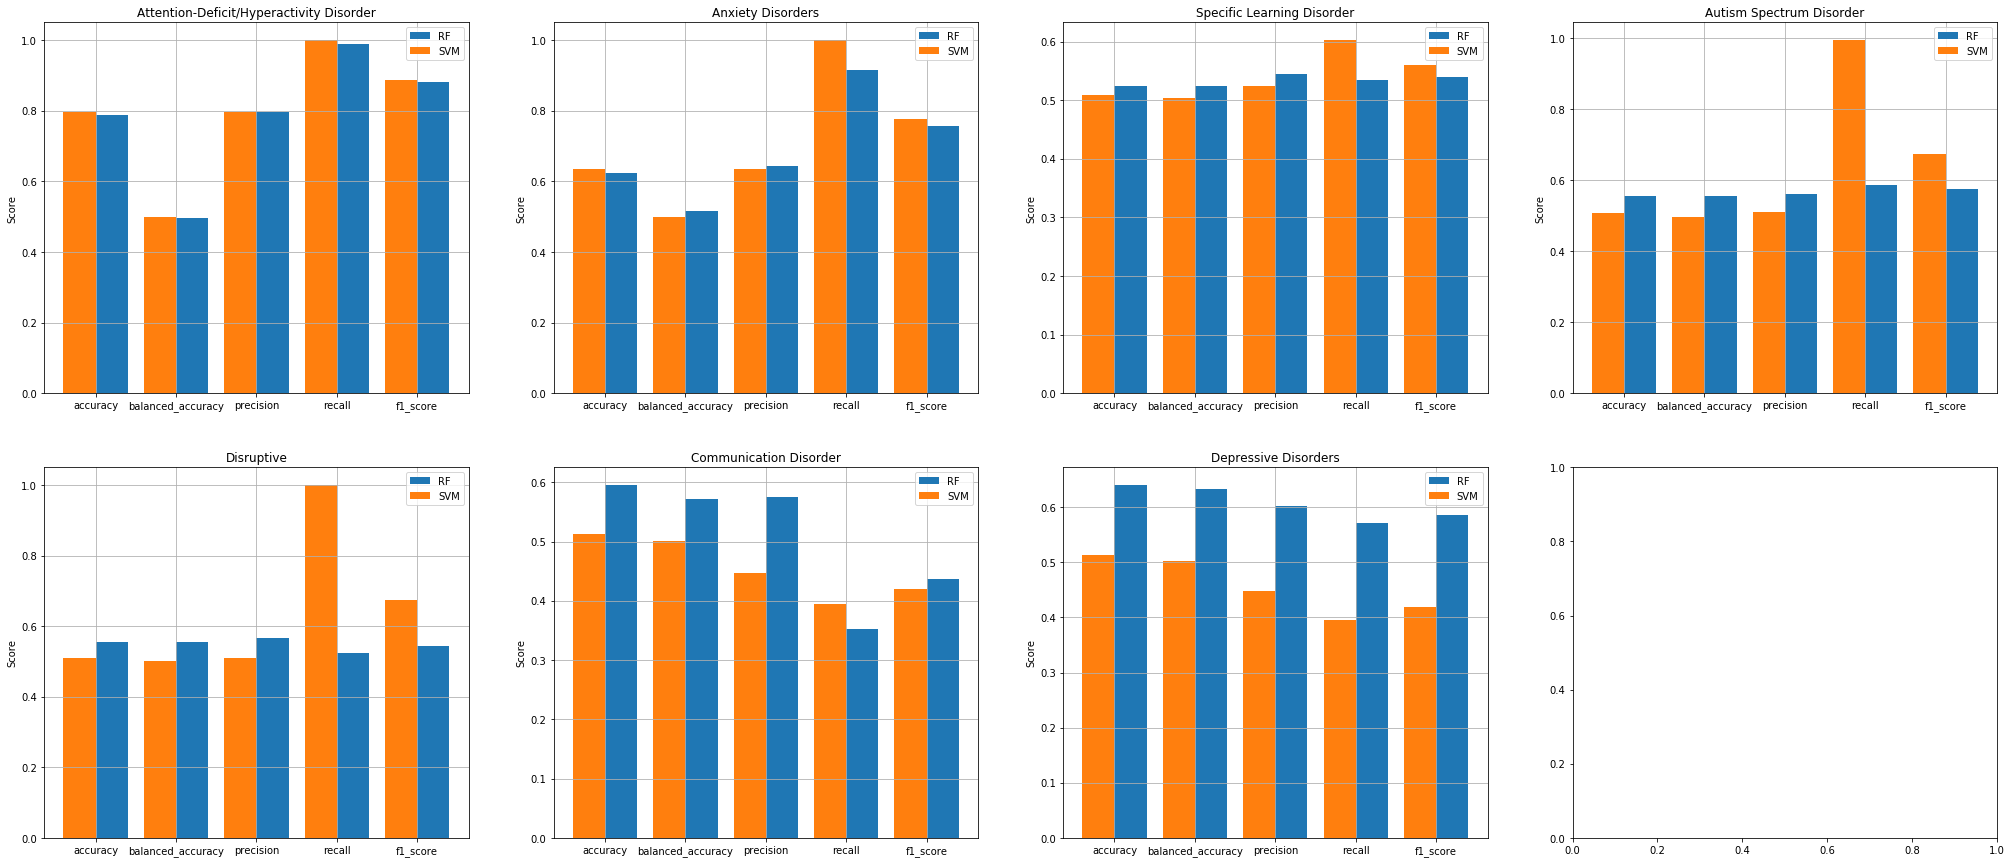

In [80]:
fig, axs = plt.subplots(nrows= 2, ncols=4, figsize=(35,15))

for ax, disorder in zip(axs.flat, rf_struct_res_vs_no_diag.keys()):
    metrics = [m for m in rf_struct_res_vs_no_diag[disorder].keys()]
    rf_scores = [v for v in rf_struct_res_vs_no_diag[disorder].values()]
    svm_scores = [v for v in svm_struct_res_vs_no_diag[disorder].values()]
    
    x = np.arange(len(metrics)) # label locations 
    width = 0.4 # the width of the bars
    
    rects_rf = ax.bar(x + width/2, rf_scores, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_scores, width, label='SVM')
                             
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()
                             
plt.show()

# Disorder vs Rest

## FA Per Track 

### Random Forest 

In [81]:
rf_param_grid = {'n_estimators': [100], 
                 'max_depth': np.linspace(start=4,stop=20,num=5),
                 'max_features': np.linspace(start=0.2,stop=1,num=5),
                 'n_jobs': [-1], 
                 'class_weight': ['balanced']}

rf_track_res_vs_rest, rf_track_y_pred_vs_rest = binary_classification(fa_per_tract, 
                                                                      labels_fa_tr, 
                                                                      most_common_disorders, 
                                                                      RandomForestClassifier(), 
                                                                      rf_param_grid,
                                                                      scale_features=True,
                                                                      scenario='Disorder vs Rest')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.558 balanced_accuracy 0.531 precision 0.595 recall 0.715 f1_score 0.650
================================= Anxiety Disorders =================================
accuracy 0.658 balanced_accuracy 0.520 precision 0.304 recall 0.226 f1_score 0.259
================================= Specific Learning Disorder =================================
accuracy 0.797 balanced_accuracy 0.483 precision 0.073 recall 0.023 f1_score 0.036
================================= Autism Spectrum Disorder =================================
accuracy 0.782 balanced_accuracy 0.538 precision 0.230 recall 0.190 f1_score 0.208
================================= Disruptive =================================
accuracy 0.810 balanced_accuracy 0.521 precision 0.224 recall 0.108 f1_score 0.146
================================= Communication Disorder =================================
accuracy 0.806 balanced_accuracy

### SVM

In [93]:
# svm_param_grid = {'C': np.logspace(-10, 10, 5), 
#                   'kernel': ['rbf'],
#                   'gamma': ['scale', 'auto'] + np.logspace(-2, 0, 5).tolist(),
#                   'class_weight': ['balanced']}

svm_param_grid = {'C': [1], 
                  'kernel': ['rbf'],
                  'gamma': ['scale'],
                  'class_weight': ['balanced']}

svm_track_res_vs_rest, svm_track_y_pred_vs_rest = binary_classification(fa_per_tract, 
                                                                        labels_fa_tr, 
                                                                        most_common_disorders, 
                                                                        SVC(), 
                                                                        svm_param_grid,
                                                                        scale_features=False,
                                                                        scenario='Disorder vs Rest')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.583 balanced_accuracy 0.558 precision 0.614 recall 0.732 f1_score 0.668
================================= Anxiety Disorders =================================
accuracy 0.678 balanced_accuracy 0.556 precision 0.366 recall 0.297 f1_score 0.328
================================= Specific Learning Disorder =================================
accuracy 0.715 balanced_accuracy 0.540 precision 0.209 recall 0.281 f1_score 0.240
================================= Autism Spectrum Disorder =================================
accuracy 0.712 balanced_accuracy 0.548 precision 0.204 recall 0.314 f1_score 0.248
================================= Disruptive =================================
accuracy 0.317 balanced_accuracy 0.533 precision 0.161 recall 0.842 f1_score 0.270
================================= Communication Disorder =================================
accuracy 0.443 balanced_accuracy

### Results

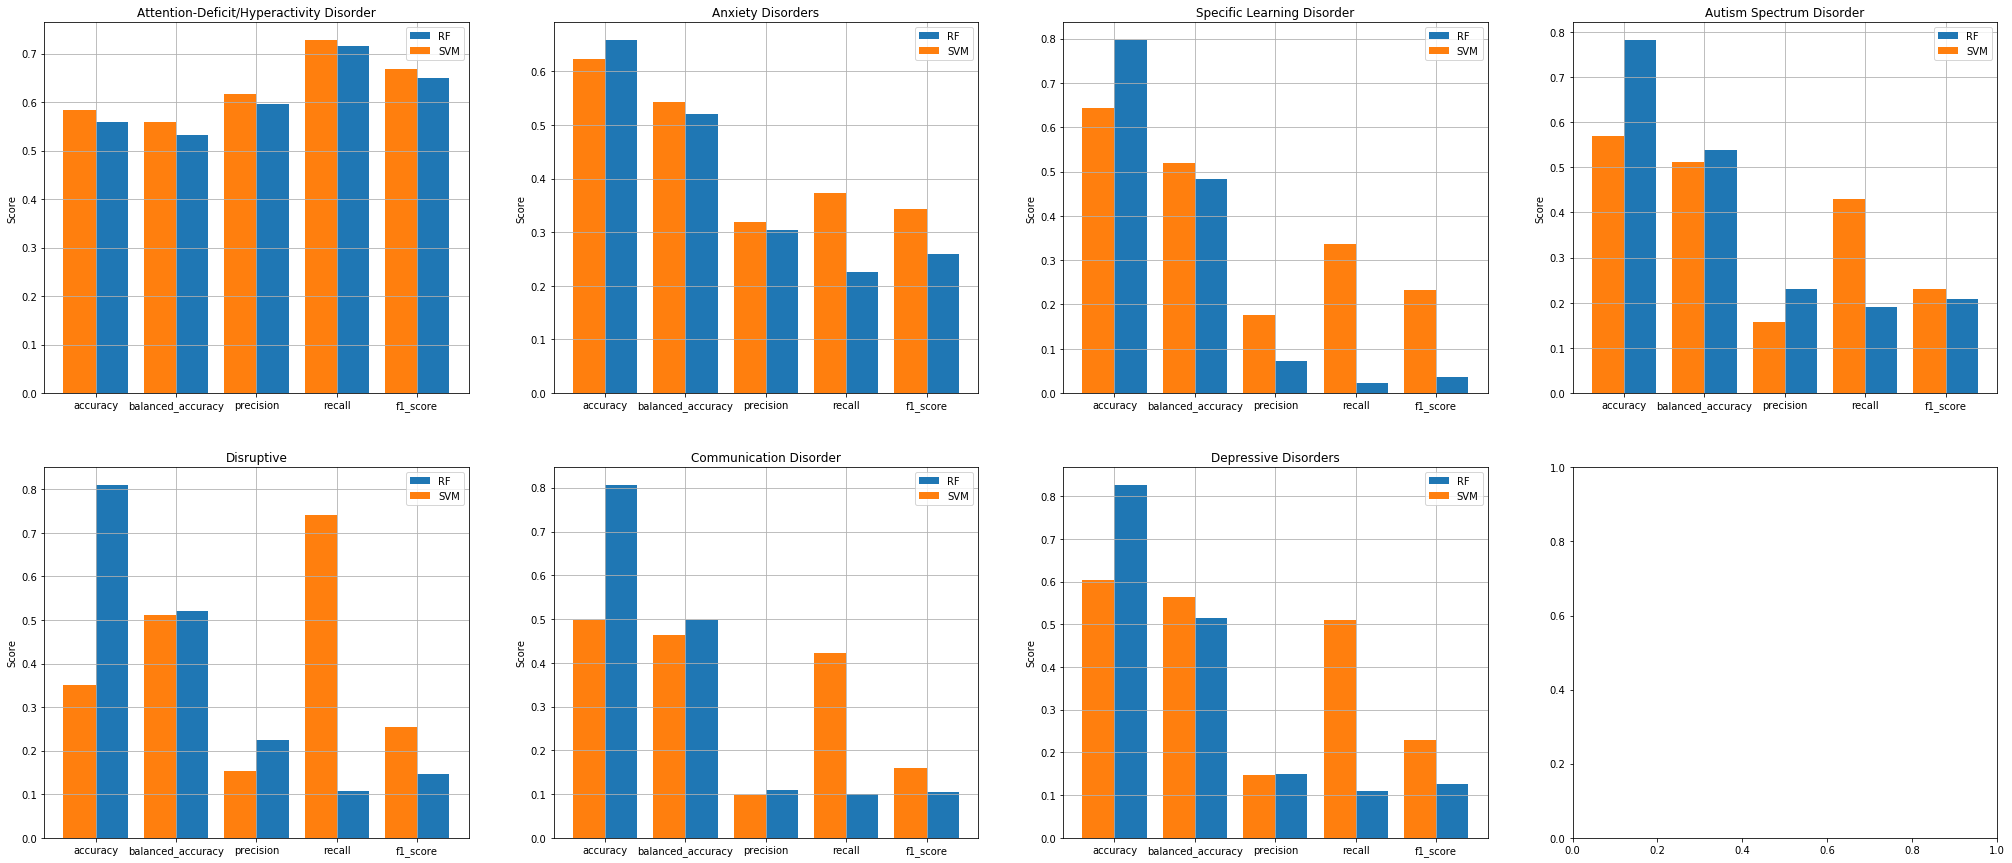

In [85]:
fig, axs = plt.subplots(nrows= 2, ncols=4, figsize=(35,15))

for ax, disorder in zip(axs.flat, rf_track_res_vs_rest.keys()):
    metrics = [m for m in rf_track_res_vs_rest[disorder].keys()]
    rf_scores = [v for v in rf_track_res_vs_rest[disorder].values()]
    svm_scores = [v for v in svm_track_res_vs_rest[disorder].values()]
    
    x = np.arange(len(metrics)) # label locations 
    width = 0.4 # the width of the bars
    
    rects_rf = ax.bar(x + width/2, rf_scores, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_scores, width, label='SVM')
                             
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()
                             
plt.show()

## Structural MRI 

### Random Forest

In [196]:
# rf_param_grid = {'n_estimators': [100], 
#                  'max_depth': np.linspace(start=4,stop=20,num=5),
#                  'max_features': np.linspace(start=0.2,stop=1,num=5),
#                  'n_jobs': [-1], 
#                  'class_weight': ['balanced']}

rf_param_grid = {'n_estimators': [100], 
                 'max_depth': [16],
                 'max_features': ["auto"],
                 'n_jobs': [-1], 
                 'class_weight': ['balanced']}

rf_struct_res_vs_rest, rf_struct_y_pred_vs_rest = binary_classification(struct_mri, 
                                                                        labels_str, 
                                                                        most_common_disorders, 
                                                                        RandomForestClassifier(), 
                                                                        rf_param_grid,
                                                                        scale_features=True,
                                                                        scenario='Disorder vs Rest')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.596 balanced_accuracy 0.567 precision 0.612 recall 0.785 f1_score 0.688
================================= Anxiety Disorders =================================
accuracy 0.652 balanced_accuracy 0.517 precision 0.281 recall 0.243 f1_score 0.261
================================= Specific Learning Disorder =================================
accuracy 0.611 balanced_accuracy 0.534 precision 0.181 recall 0.422 f1_score 0.254
================================= Autism Spectrum Disorder =================================
accuracy 0.685 balanced_accuracy 0.494 precision 0.144 recall 0.219 f1_score 0.174
================================= Disruptive =================================
accuracy 0.614 balanced_accuracy 0.488 precision 0.139 recall 0.307 f1_score 0.192
================================= Communication Disorder =================================
accuracy 0.647 balanced_accuracy

### SVM 

In [201]:
# svm_param_grid = {'C': np.logspace(-10, 10, 5), 
#                   'kernel': ['rbf'],
#                   'gamma': ['scale', 'auto'] + np.logspace(-2, 0, 5).tolist(),
#                   'class_weight': ['balanced']}

svm_param_grid = {'C': [1], 
                  'kernel': ['rbf'],
                  'gamma': ['scale'],
                  'class_weight': ['balanced']}

svm_struct_res_vs_rest, svm_struct_y_pred_vs_rest = binary_classification(struct_mri, 
                                                                          labels_str, 
                                                                          most_common_disorders, 
                                                                          SVC(), 
                                                                          svm_param_grid,
                                                                          scale_features=True,
                                                                          scenario='Disorder vs Rest')

================================= Attention-Deficit/Hyperactivity Disorder =================================
accuracy 0.565 balanced_accuracy 0.574 precision 0.649 recall 0.505 f1_score 0.568
================================= Anxiety Disorders =================================
accuracy 0.660 balanced_accuracy 0.536 precision 0.311 recall 0.286 f1_score 0.298
================================= Specific Learning Disorder =================================
accuracy 0.809 balanced_accuracy 0.500 precision 0.157 recall 0.050 f1_score 0.075
================================= Autism Spectrum Disorder =================================
accuracy 0.832 balanced_accuracy 0.500 precision 0.154 recall 0.026 f1_score 0.044
================================= Disruptive =================================
accuracy 0.820 balanced_accuracy 0.498 precision 0.136 recall 0.039 f1_score 0.061
================================= Communication Disorder =================================
accuracy 0.873 balanced_accuracy

### Results

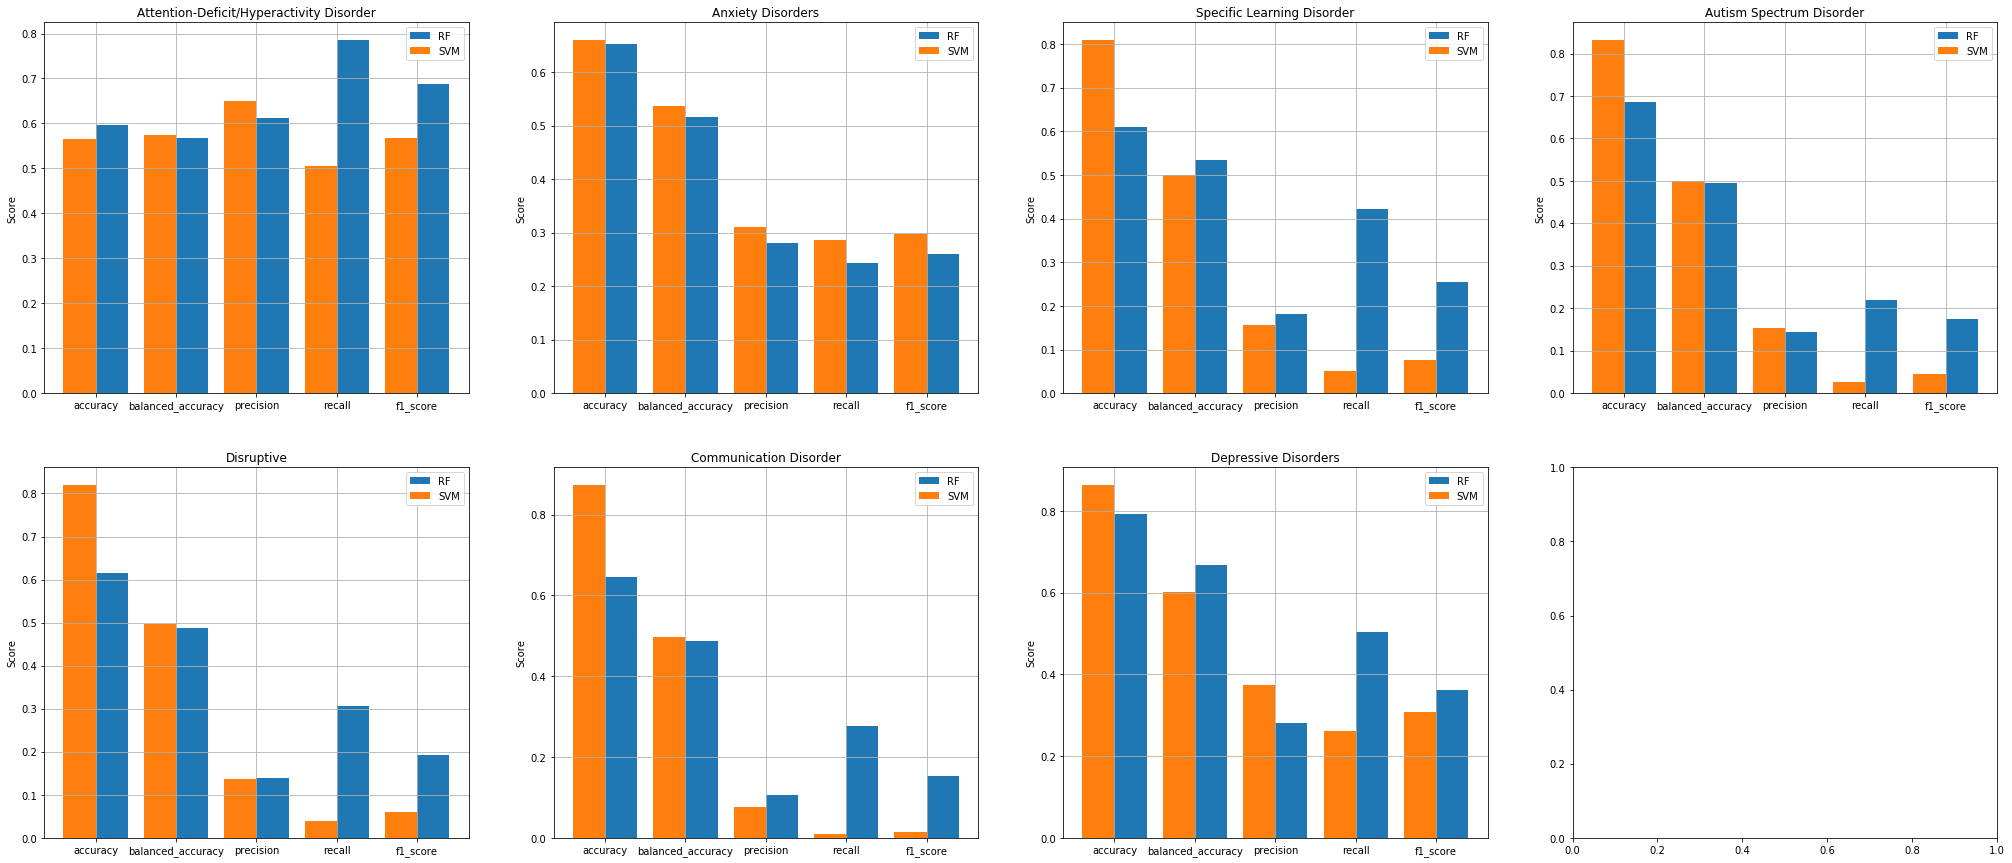

In [203]:
fig, axs = plt.subplots(nrows= 2, ncols=4, figsize=(35,15))

for ax, disorder in zip(axs.flat, rf_struct_res_vs_rest.keys()):
    metrics = [m for m in rf_struct_res_vs_rest[disorder].keys()]
    rf_scores = [v for v in rf_struct_res_vs_rest[disorder].values()]
    svm_scores = [v for v in svm_struct_res_vs_rest[disorder].values()]
    
    x = np.arange(len(metrics)) # label locations 
    width = 0.4 # the width of the bars
    
    rects_rf = ax.bar(x + width/2, rf_scores, width, label='RF')
    rects_svm = ax.bar(x - width/2, svm_scores, width, label='SVM')
                             
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title(disorder)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.grid(True)
    ax.legend()
                             
plt.show()